##### Installing latest version of albumentation because old code doesn't has Coarseout

In [0]:
!pip install albumentations==0.4.5

     |████████████████████████████████| 122kB 17.0MB/s 
     |████████████████████████████████| 634kB 38.7MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=a59de1edab15f118367d9b0882f7a8bbc94a2111372b69588da3888db0f4b667
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=f3b6a68a8ad5e08940b0b5ce68bc619ce442133f6a9c26a36316473e2dc148e0
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [0]:
%matplotlib inline

### Importing Libraries

In [0]:
#connect google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls

drive  sample_data


In [0]:
# Changing working directory
import os
os.chdir('drive/My Drive/EVA4/assignment10')

In [0]:
!ls

10_final.ipynb	  gradcam.py	Misclassified_Images.png  torch_lr_finder
assign10	  img1.png	model.py		  trainalbumentation.py
data		  __init__.py	__pycache__		  train_.py
dataset.py	  lr_finder.py	testalbumentation.py
general_utils.py  map.jpg	test_.py


In [0]:
# checking present working directory
!pwd

/content/drive/My Drive/EVA4/assignment10


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
from gradcam import *

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from dataset import Data
from model import ResNet18

### Downloading train and test dataset using (dataset) module

In [0]:
data = Data()
trainset = data.getTrainDataSet(train=True)
testset = data.getTestDataSet(train=False)

Files already downloaded and verified
Files already downloaded and verified


### Creating Test/Train Dataloaders, another train and test loaders to visualise image and gradcam loader which will be used in visualising images using GradCAM

In [0]:
train_loader = data.getDataLoader(dataset=trainset,batches=128)
test_loader = data.getDataLoader(testset,128)
img_train_loader = data.getDataLoader(trainset,4)
img_test_loader = data.getDataLoader(testset,4)
test_grad_loader = data.getDataLoader(testset,1)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#### Visualizing images



plane   cat   dog plane


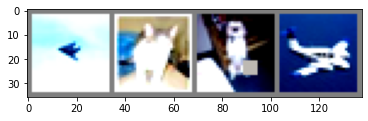

In [0]:
from general_utils import imshow

# get some random training images
dataiter = iter(img_train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Model Parameters

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

netobj = ResNet18()
model = netobj.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

### Finding Best Learning rate through (lr_finder) module

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


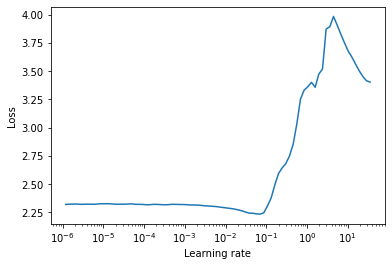

In [0]:
from general_utils import lr_finder
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder(model, optimizer, criterion, train_loader)
#lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(train_loader, end_lr=100, num_iter=100, step_mode="exp")

### Training and Testing Loss

In [0]:
from train_ import train
from test_ import test
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau


model =  netobj.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.9, weight_decay=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
EPOCHS = 50


test_acc = []
train_acc = []
trainloss_ = []
testloss_ = []
loss=1000
loss = 1000
for epoch in range(50):  # loop over the dataset multiple times
    for param_group in optimizer.param_groups:
      print("lr= ",param_group['lr'])
    print("EPOCH :", epoch)
    trainacc, loss = train(model, device, train_loader, optimizer, criterion, epoch)
    train_acc.append(trainacc)
    testacc, loss1 = test(model, device, test_loader, criterion)
    test_acc.append(testacc)
    trainloss_.append(loss)
    testloss_.append(loss1)
    scheduler.step(loss1)
print('Finished Training')

  0%|          | 0/391 [00:00<?, ?it/s]

lr=  0.1
EPOCH : 0


Epoch= 0 Loss=1.5123251676559448 Batch_id=390 Accuracy=45.00: 100%|██████████| 391/391 [01:14<00:00,  5.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 1.6498334 Test Accuracy= 43.29
lr=  0.1
EPOCH : 1


Epoch= 1 Loss=1.2597752809524536 Batch_id=390 Accuracy=62.50: 100%|██████████| 391/391 [01:17<00:00,  5.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 1.1307361 Test Accuracy= 58.38
lr=  0.1
EPOCH : 2


Epoch= 2 Loss=1.1895872354507446 Batch_id=390 Accuracy=62.50: 100%|██████████| 391/391 [01:16<00:00,  5.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.68496805 Test Accuracy= 67.05
lr=  0.1
EPOCH : 3


Epoch= 3 Loss=0.7186205983161926 Batch_id=390 Accuracy=78.75: 100%|██████████| 391/391 [01:16<00:00,  5.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.48704386 Test Accuracy= 74.0
lr=  0.1
EPOCH : 4


Epoch= 4 Loss=0.687415599822998 Batch_id=390 Accuracy=80.00: 100%|██████████| 391/391 [01:17<00:00,  5.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 1.1058831 Test Accuracy= 78.58
lr=  0.1
EPOCH : 5


Epoch= 5 Loss=0.5043783783912659 Batch_id=390 Accuracy=91.25: 100%|██████████| 391/391 [01:17<00:00,  5.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.6915033 Test Accuracy= 80.57
lr=  0.1
EPOCH : 6


Epoch= 6 Loss=0.5488005876541138 Batch_id=390 Accuracy=88.75: 100%|██████████| 391/391 [01:17<00:00,  5.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.4049392 Test Accuracy= 82.08
lr=  0.1
EPOCH : 7


Epoch= 7 Loss=0.5193403959274292 Batch_id=390 Accuracy=88.75: 100%|██████████| 391/391 [01:17<00:00,  5.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.41967934 Test Accuracy= 83.4
lr=  0.1
EPOCH : 8


Epoch= 8 Loss=0.27697452902793884 Batch_id=390 Accuracy=95.00: 100%|██████████| 391/391 [01:17<00:00,  5.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.27373827 Test Accuracy= 84.39
lr=  0.1
EPOCH : 9


Epoch= 9 Loss=0.32973194122314453 Batch_id=390 Accuracy=91.25: 100%|██████████| 391/391 [01:17<00:00,  5.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.5875218 Test Accuracy= 83.37
lr=  0.1
EPOCH : 10


Epoch= 10 Loss=0.2828597128391266 Batch_id=390 Accuracy=96.25: 100%|██████████| 391/391 [01:17<00:00,  5.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.17574593 Test Accuracy= 86.24
lr=  0.1
EPOCH : 11


Epoch= 11 Loss=0.1646014153957367 Batch_id=390 Accuracy=97.50: 100%|██████████| 391/391 [01:16<00:00,  5.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.57582146 Test Accuracy= 85.61
lr=  0.1
EPOCH : 12


Epoch= 12 Loss=0.26126980781555176 Batch_id=390 Accuracy=97.50: 100%|██████████| 391/391 [01:17<00:00,  5.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.27803802 Test Accuracy= 85.48
lr=  0.1
EPOCH : 13


Epoch= 13 Loss=0.18847133219242096 Batch_id=390 Accuracy=96.25: 100%|██████████| 391/391 [01:17<00:00,  5.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.22922942 Test Accuracy= 86.66
lr=  0.1
EPOCH : 14


Epoch= 14 Loss=0.21946251392364502 Batch_id=390 Accuracy=97.50: 100%|██████████| 391/391 [01:16<00:00,  5.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.71463203 Test Accuracy= 84.94
lr=  0.05
EPOCH : 15


Epoch= 15 Loss=0.05956057459115982 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [01:16<00:00,  5.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.432046 Test Accuracy= 89.43
lr=  0.05
EPOCH : 16


Epoch= 16 Loss=0.0780767872929573 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [01:17<00:00,  5.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.26869252 Test Accuracy= 88.93
lr=  0.05
EPOCH : 17


Epoch= 17 Loss=0.09490491449832916 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [01:17<00:00,  5.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.6207756 Test Accuracy= 89.28
lr=  0.05
EPOCH : 18


Epoch= 18 Loss=0.052327901124954224 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:16<00:00,  5.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.44001862 Test Accuracy= 89.39
lr=  0.025
EPOCH : 19


Epoch= 19 Loss=0.05902609974145889 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [01:17<00:00,  5.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.45499298 Test Accuracy= 90.06
lr=  0.025
EPOCH : 20


Epoch= 20 Loss=0.02836495079100132 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:17<00:00,  5.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.14469838 Test Accuracy= 90.31
lr=  0.025
EPOCH : 21


Epoch= 21 Loss=0.02139303646981716 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:17<00:00,  5.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.27680984 Test Accuracy= 90.35
lr=  0.025
EPOCH : 22


Epoch= 22 Loss=0.019117027521133423 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:16<00:00,  5.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.86188716 Test Accuracy= 89.88
lr=  0.025
EPOCH : 23


Epoch= 23 Loss=0.006897866725921631 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:17<00:00,  5.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.7032445 Test Accuracy= 90.27
lr=  0.025
EPOCH : 24


Epoch= 24 Loss=0.004496121313422918 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:16<00:00,  5.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.31070104 Test Accuracy= 90.35
lr=  0.0125
EPOCH : 25


Epoch= 25 Loss=0.013602388091385365 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:17<00:00,  5.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.3593832 Test Accuracy= 90.6
lr=  0.0125
EPOCH : 26


Epoch= 26 Loss=0.03450096771121025 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [01:17<00:00,  5.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.18752003 Test Accuracy= 90.73
lr=  0.0125
EPOCH : 27


Epoch= 27 Loss=0.030811602249741554 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:16<00:00,  5.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.9418331 Test Accuracy= 90.59
lr=  0.0125
EPOCH : 28


Epoch= 28 Loss=0.07312172651290894 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [01:17<00:00,  5.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.3063342 Test Accuracy= 90.7
lr=  0.00625
EPOCH : 29


Epoch= 29 Loss=0.0029149590991437435 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:17<00:00,  5.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.05469647 Test Accuracy= 90.74
lr=  0.00625
EPOCH : 30


Epoch= 30 Loss=0.007004410028457642 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:17<00:00,  5.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.2910376 Test Accuracy= 90.72
lr=  0.00625
EPOCH : 31


Epoch= 31 Loss=0.001278007053770125 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:17<00:00,  5.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.37462485 Test Accuracy= 90.88
lr=  0.00625
EPOCH : 32


Epoch= 32 Loss=0.0035407363902777433 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:17<00:00,  5.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.8330813 Test Accuracy= 90.62
lr=  0.00625
EPOCH : 33


Epoch= 33 Loss=0.004569208715111017 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:18<00:00,  5.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.04147789 Test Accuracy= 90.85
lr=  0.00625
EPOCH : 34


Epoch= 34 Loss=0.0017037272918969393 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:17<00:00,  5.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.11748293 Test Accuracy= 90.73
lr=  0.00625
EPOCH : 35


Epoch= 35 Loss=0.006344503257423639 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:16<00:00,  5.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.14275476 Test Accuracy= 90.8
lr=  0.00625
EPOCH : 36


Epoch= 36 Loss=0.002796429442241788 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:16<00:00,  5.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.000839293 Test Accuracy= 90.85
lr=  0.00625
EPOCH : 37


Epoch= 37 Loss=0.004674184136092663 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:17<00:00,  5.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.35070598 Test Accuracy= 90.7
lr=  0.00625
EPOCH : 38


Epoch= 38 Loss=0.003927850630134344 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:17<00:00,  5.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.0024410486 Test Accuracy= 90.84
lr=  0.00625
EPOCH : 39


Epoch= 39 Loss=0.008460909128189087 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:17<00:00,  5.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.09134573 Test Accuracy= 90.68
lr=  0.00625
EPOCH : 40


Epoch= 40 Loss=0.006428241729736328 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:16<00:00,  5.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.8066479 Test Accuracy= 90.73
lr=  0.003125
EPOCH : 41


Epoch= 41 Loss=0.03427452966570854 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [01:17<00:00,  5.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.03370601 Test Accuracy= 90.6
lr=  0.003125
EPOCH : 42


Epoch= 42 Loss=0.0011128544574603438 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:17<00:00,  5.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.19729587 Test Accuracy= 90.84
lr=  0.003125
EPOCH : 43


Epoch= 43 Loss=0.0070192874409258366 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:17<00:00,  5.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.0008852482 Test Accuracy= 90.72
lr=  0.003125
EPOCH : 44


Epoch= 44 Loss=0.0025783181190490723 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:17<00:00,  5.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.57738733 Test Accuracy= 90.76
lr=  0.0015625
EPOCH : 45


Epoch= 45 Loss=0.001134073711000383 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:17<00:00,  5.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.14882621 Test Accuracy= 90.64
lr=  0.0015625
EPOCH : 46


Epoch= 46 Loss=0.0026853501331061125 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:16<00:00,  5.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.77674013 Test Accuracy= 90.8
lr=  0.0015625
EPOCH : 47


Epoch= 47 Loss=0.003787511494010687 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:17<00:00,  5.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.674089 Test Accuracy= 90.59
lr=  0.0015625
EPOCH : 48


Epoch= 48 Loss=0.0007427573436871171 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:17<00:00,  5.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss= 0.8298829 Test Accuracy= 90.8
lr=  0.00078125
EPOCH : 49


Epoch= 49 Loss=0.004010808654129505 Batch_id=390 Accuracy=100.00: 100%|██████████| 391/391 [01:16<00:00,  5.10it/s]
100%|██████████| 79/79 [00:03<00:00, 19.76it/s]

Test Loss= 0.47275516 Test Accuracy= 90.84
Finished Training


In [0]:
torch.save(model,'assign10')

### Plotting Train and Test Accuracy curves

Text(0, 0.5, 'Accuracy')

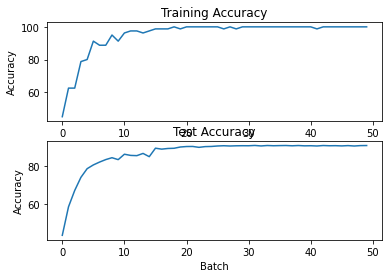

In [0]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
axs[0].plot(train_acc)
axs[0].set_title("Training Accuracy")
axs[0].set_xlabel("Batch")
axs[0].set_ylabel("Accuracy")
axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")
axs[1].set_xlabel("Batch")
axs[1].set_ylabel("Accuracy")

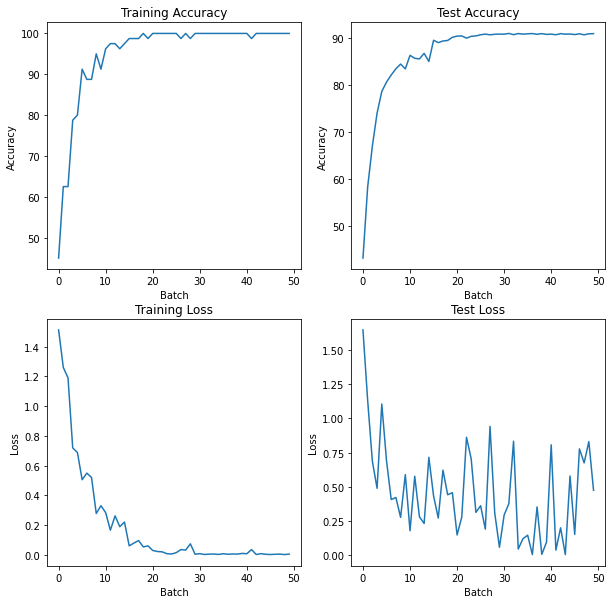

In [0]:
from general_utils import plot_acc_loss
plot_acc_loss(train_acc, test_acc, trainloss_, testloss_)

### Checking Ground Truth and Predicted Class

GT      cat      horse      truck       deer
Pred    cat      horse      truck       deer


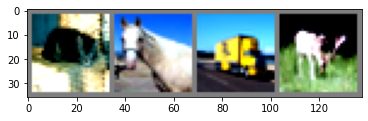

In [0]:
from general_utils import imshow
dataiter = iter(img_test_loader)
images, labels = dataiter.next()

# print images (Ground Truth)
imshow(torchvision.utils.make_grid(images))
print('GT   ', '      '.join('%5s' % classes[labels[j]] for j in range(4)))

# print predicted images
outputs = model(images.cuda())
_, predicted = torch.max(outputs, 1)
print('Pred ', '      '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [0]:
def OverallAcc(testloader, model):
  # dataiter = iter(testloader)
  # images, labels = dataiter.next()
  correct = 0
  total = 0

  with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

  print('Accuracy of the network on the 10000 test images: %d %%' % (
      100 * correct / total))
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  with torch.no_grad():
      for data in test_loader:
          images, labels = data
          images = images.cuda()
          labels = labels.cuda()
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          c = (predicted == labels).squeeze()
          for i in range(4):
              label = labels[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1


  for i in range(10):
      print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))

In [0]:
# from general_utils import OverallAcc
OverallAcc(testloader = test_loader, model = model)

Accuracy of the network on the 10000 test images: 90 %
Accuracy of plane : 94 %
Accuracy of   car : 90 %
Accuracy of  bird : 96 %
Accuracy of   cat : 75 %
Accuracy of  deer : 91 %
Accuracy of   dog : 81 %
Accuracy of  frog : 91 %
Accuracy of horse : 97 %
Accuracy of  ship : 92 %
Accuracy of truck : 90 %


### Analyzing 25 missclassified images through GradCam


In [0]:
# mod = torch.load('assign10')

In [0]:
import gradcam
it = iter(test_grad_loader)

/content/drive/My Drive/EVA4/assignment10/gradcam.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=1, ncols=3)


<Figure size 1008x1152 with 0 Axes>

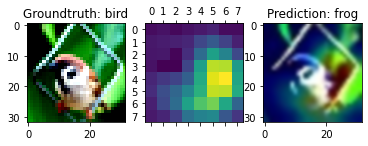

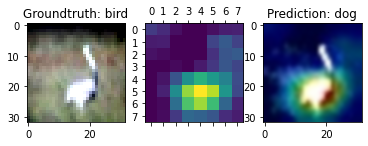

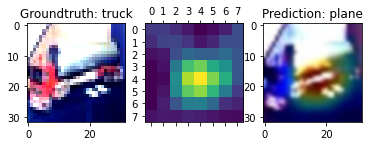

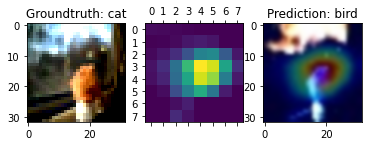

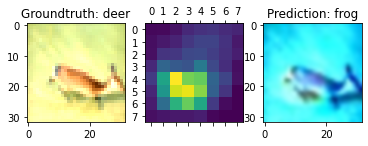

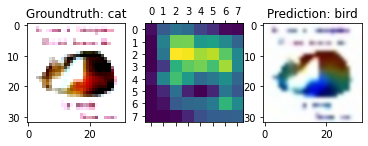

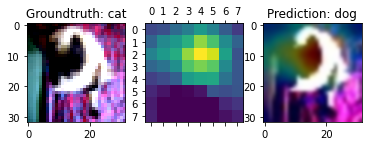

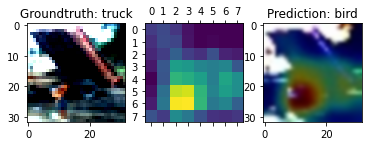

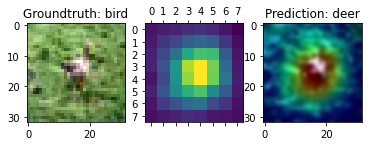

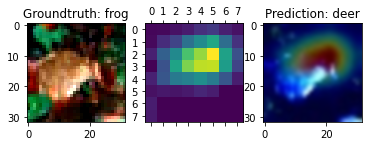

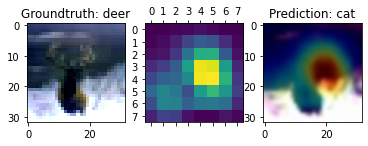

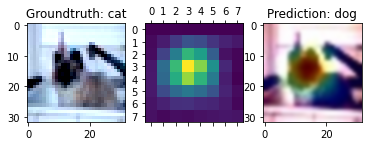

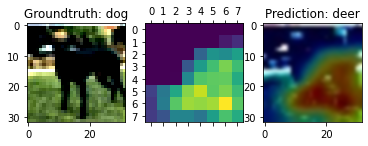

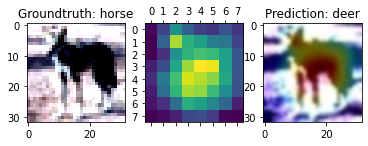

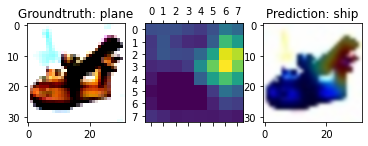

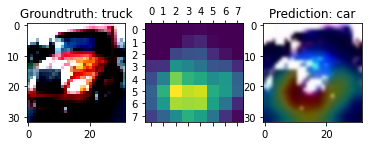

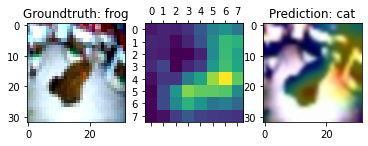

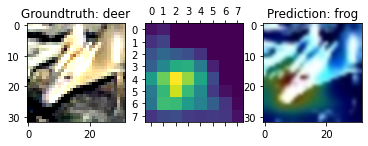

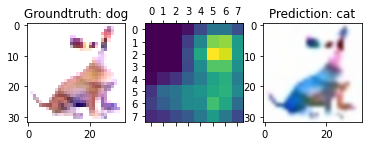

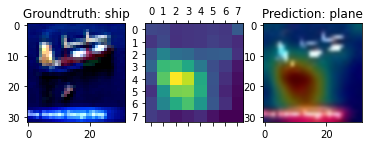

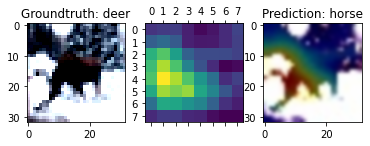

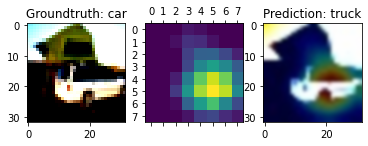

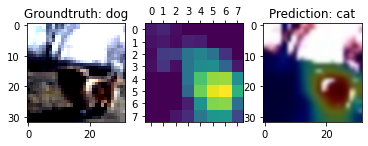

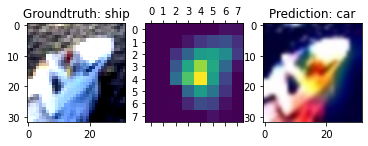

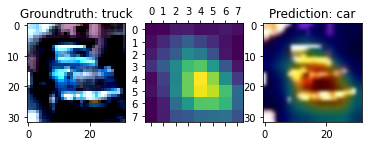

In [0]:
fig=plt.figure(figsize=(14, 16))
count = 0
while(count != 25):
    images, labels = it.next()
    output = model(images.cuda())
    pred = output.argmax(dim=1, keepdim=True)
    if(classes[pred] != classes[labels]):
      gradcam.gradcamof(model, images, classes, str(classes[labels]), str(classes[pred]))
      count=count+1

from google.colab import files
plt.savefig("Misclassified_Images.png")
files.download("Misclassified_Images.png")